In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import io
import sys
import re
import copy
import numpy as np
from scipy.spatial import procrustes
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from l2gx.align.utils import to_device
import networkx as nx
from scipy.stats import special_ortho_group
from umap import UMAP
from sklearn.manifold import TSNE
import warnings
# Suppress common UMAP and sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, SpectralClustering

# 🌌 <font color="grey"> Local2Global X - Graph Representation Learning at Scale</font>

#### <font color="grey">  Table of Contents</font>

🏗️ <a href='#chapter1'>Structure</a>

📊 <a href='#chapter2'>Datasets</a>

🌐 <a href='#chapter3'>Graphs</a>

🧩 <a href='#chapter4'>Patches</a>

🎯 <a href='#chapter5'>Embedding</a>

🔗 <a href='#chapter6'>Alignment</a>

🌳 <a href='#chapter7'>Hierarchical alignment</a>

📈 <a href='#chapter8'>Visualisation</a>

###  <a id='chapter1'> 🏗️ <font color="grey">Structure </font></a>

There are five main parts to the package, organised as follows.

```
l2gv2/
├── datasets/
├── graphs/
├── patch/
├── embedding/
└── align/
    ├── l2g/
    └── geo/
```

A brief overview of the contents:

* ```datasets``` contains interfaces are provided for various common benchmark datasets. 
* ```graphs``` contains wrappers for graphs represented as lists of edges in pytorch-geometric ```data.edge_index``` format. These implemented features such as fast adjacency look-up and a variety of algorithms on graphs.
* ```patch``` directory contains datastructures to represent patches and patch graphs, as well as methods to subdivide a graph into patches. 
* ```embedding``` contains various graph embedding methods, including Graph Autoencoders (GAE) and [Variational Graph Autoencoders (VGAE)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html).
* ```align``` contains two methods to compute the alignment of patches into a single graph embedding: eigenvalue synchronisation based on the [Local2Global](https://link.springer.com/article/10.1007/s10994-022-06285-7) algorithm, and the new method based on learning the alignment using a one-layer neural network.

###  <a id='chapter2'> 📊 <font color="grey">Datasets </font></a>

The L2Gv2 framework provides access to multiple graph datasets spanning different domains and scales. All datasets are accessible through the unified `get_dataset()` interface and support conversion between multiple formats (PyTorch Geometric, Raphtory, Polars).

| Dataset | Type | Nodes | Edges | Features | Domain |
|---------|------|-------|-------|----------|--------|
| **Cora** | Static Citation | 2,708 | 10,556 | 1,433 | 📚 Academic Papers |
| **AS-733** | Temporal Network | 7,716 | 45,645 | Temporal | 🌐 Internet Infrastructure |
| **DGraph** | Financial | ~3M | ~4M | Multiple | 💰 Fraud Detection |
| **Elliptic** | Bitcoin | 203,769 | 234,355 | 166 | ₿ Cryptocurrency |
| **MAG240M** | Academic | 244M+ | 1.7B+ | Rich | 🎓 Citation Graph |
| **ORBITAAL** | Bitcoin Temporal | 252M (1K sample) | 785M (5K sample) | Temporal + Anomaly | ₿ Financial Fraud |

#### Dataset Details

* **Cora**: The [Cora dataset](https://graphsandnetworks.com/the-cora-dataset/) is a citation network of 2,708 scientific publications divided into 7 classes. Each node has a 1,433-dimensional feature vector indicating word presence/absence. Accessed through PyTorch Geometric's [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html) dataset.

* **AS-733**: The [SNAP autonomous systems AS-733](https://snap.stanford.edu/data/as-733.html) dataset contains 733 daily snapshots spanning 785 days (November 1997 to January 2000). Nodes represent autonomous systems and edges indicate communication events.

* **DGraph**: [DGraph](https://dgraph.xinye.com/dataset) is a real-world financial graph for anomaly detection research. Described in [DGraph: A Large-Scale Financial Dataset for Graph Anomaly Detection](https://arxiv.org/abs/2207.03579). Requires manual download.

* **Elliptic**: The [Elliptic dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) maps Bitcoin transactions to licit/illicit categories. Contains 203,769 transactions with 166 features each. Used in [Anti-Money Laundering in Bitcoin](https://arxiv.org/pdf/1908.02591) research. Requires manual download from Kaggle.

* **MAG240M**: The [MAG240M](https://ogb.stanford.edu/docs/lsc/mag240m/) dataset is a large heterogeneous academic citation graph with 244+ million nodes (papers, authors, institutions, fields) and 1.7+ billion edges. Requires the OGB library and substantial storage (~100GB).

* **ORBITAAL**: The [ORBITAAL](https://www.nature.com/articles/s41597-025-04595-8) dataset is a comprehensive temporal Bitcoin transaction graph covering 13 years (2009-2021) with 252M entities and 785M transactions. Features timestamped transactions, entity types (exchanges, wallets, services, miners), and anomaly labels for financial fraud detection. Ideal for temporal graph neural networks and cryptocurrency flow analysis.


For the datasets requiring manual download, provide the path:
```
elliptic = get_dataset("Elliptic", source_file="/path/to/elliptic.zip")
dgraph = get_dataset("DGraph", source_file="/path/to/dgraph.zip")
```

All datasets support conversion to different formats and follow the PyTorch Geometric convention. Temporal graphs return iterables over time slices, and graphs can be exported to Raphtory or NetworkX formats for analysis.

In [3]:
from l2gx.datasets import get_dataset, list_available_datasets
datasets = list_available_datasets()
print(f"Current datasets: {datasets}")

Current datasets: ['as-733', 'Cora', 'DGraph', 'Elliptic', 'MAG240M', 'ORBITAAL']


In [4]:
cora = get_dataset("Cora")
tg = cora.to("torch-geometric")
print(tg)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
G = cora.to("networkx")
labels = tg.y.numpy()
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Labels: {len(np.unique(labels))} unique classes")


Loading edge and node data from memory
Graph: 2708 nodes, 5278 edges
Labels: 7 unique classes


In [ ]:
edge_index = dataset.edge_index('paper', 'paper')

###  <a id='chapter3'> 🌐 <font color="grey">Graphs </font></a>

```TGraph``` is a wrapper for torch-geometric ```Data`` objects. These include, among other things, methods for fast adjacency look-up and various optimizations. These are mostly used when performing graph clustering and generating patches.

In [6]:
from l2gx.graphs import TGraph

In [7]:
tg = TGraph(cora[0].edge_index, edge_attr=cora[0].edge_attr, x=cora[0].x)
print(tg.adj_index)
print(tg.x)

tensor([    0,     3,     6,  ..., 10548, 10552, 10556])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In a future iteration one can think about consolidating this part by having graphs represented in some existing graph package like Raphtory.

###  <a id='chapter4'> 🧩 <font color="grey">Patches </font></a>

A patch can equivalently refer to a subgraph or to an embedding of this subgraph. As a set of points, a patch is represented using the ```Patch``` class. A ```Patch``` object has the properties ```nodes```, ```index``` and ```coordinates```. ```nodes``` is simply a list of the nodes from the original graph that are present in the patch. ```index``` is a dict that maps each node to an index into ```coordinates```, which is just a list of coordinates. For example, if a graph embedding consists of four nodes in two dimensions as follows, and a patch is represented by the solid circles, then the corresponding object would have the following properties:

![Patch](./images/square_patch.png)


In [8]:
from l2gx.patch.patches import Patch

In [9]:
p = Patch([0,2,3], np.array([[0., 0.], [1., 0.], [1., 1.]]))
print(p.coordinates)
print(p.nodes)
print(p.index)

[[0. 0.]
 [1. 0.]
 [1. 1.]]
[0 2 3]
{0: 0, 2: 1, 3: 2}


In [10]:
from l2gx.patch.clustering.fennel import fennel_clustering
from l2gx.patch.clustering.metis import metis_clustering
from l2gx.patch import generate_patches

In [11]:
patches, patch_graph = generate_patches(tg, num_patches=10, clustering_method='metis')

Generating patches from graph with 2708 nodes, 10556 edges
Target patches: 10 → ~270 nodes per patch
Overlap: min=27, target=54
Step 1: Clustering with metis...
Clustering complete: 10 clusters, sizes: [260, 284]
Step 2: Creating patches with resistance sparsification...
number of patches: 10
average patch degree: 3.8


enlarging patch overlaps:   0%|          | 0/10 [00:00<?, ?it/s]

Patch generation complete: 10 patches created
Patch sizes: [285, 397], avg: 346.8


The patches from the nodes of a **patch graph**, where two nodes are connected by an edge if the patches contain overlapping nodes. The alignment tasks consists of making the correponding coordinates overlap as much as possible.

In [12]:
print([len(p.nodes) for p in patches])

[360, 285, 304, 351, 397, 346, 392, 331, 358, 344]


###  <a id='chapter5'> 🎯 <font color="grey">Embedding </font></a>

The L2GX framework implements several graph embedding methods: ```SVDEmbedding```, ```GAEEmbedding```, ```VGAEEmbedding```, ```GraphSAGEEmbedding``` and ```DGIEmbedding```. The first three are based on transductive learning, while the last two are inductive.

* <font color="grey">SVD</font> - Classical spectral approach using eigendecomposition
* <font color="grey">GAE</font> - [Graph Auto-Encoder ](https://arxiv.org/abs/1611.07308) for deterministic reconstruction
* <font color="grey">VGAE</font> - [Variational Graph Auto-Encoder](https://arxiv.org/abs/1611.07308) with probabilistic latent variables
* <font color="grey">GraphSAGE</font> - [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216) for scalable embedding
* <font color="grey">DGI</font> - [Deep Graph Infomax](https://arxiv.org/abs/1809.10341) using self-supervised contrastive learning

All methods are accessible through a unified interface with the ```get_embedding()``` function and registry system. The demonstration below shows convergence analysis, quality metrics, and UMAP visualizations for comprehensive comparison.

In [14]:
from l2gx.embedding import get_embedding

In [15]:
print("📚 Loading Cora dataset...")
cora_data = cora[0]
print(f"Cora dataset: {cora_data.num_nodes} nodes, {cora_data.num_edges} edges")
print(f"Node features: {cora_data.x.shape}")
print(f"Classes: {cora_data.y.unique().numel()}")
print()

📚 Loading Cora dataset...
Cora dataset: 2708 nodes, 10556 edges
Node features: torch.Size([2708, 1433])
Classes: 7



In [21]:
def capture_training_output(func, *args, **kwargs):
    """Capture stdout and parse training loss values."""
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()
    
    try:
        result = func(*args, **kwargs)
        output = captured_output.getvalue()
    finally:
        sys.stdout = old_stdout
    
    # Parse loss values from output using regex
    loss_pattern = r'Epoch\s+(\d+),\s+Loss:\s+([\d.]+)'
    matches = re.findall(loss_pattern, output)
    
    if matches:
        epochs = [int(match[0]) for match in matches]
        losses = [float(match[1]) for match in matches]
        # Print the captured output so user can still see it
        print(output, end='')
        return result, (epochs, losses)
    else:
        print(output, end='')
        return result, None

In [24]:
start_time = time.time()
embedder = get_embedding('vgae', embedding_dim=64, num_epochs=200)
embedding, loss_data = capture_training_output(embedder.fit_transform, cora_data)
if loss_data:
    epochs, losses = loss_data
    training_history = {'epochs': epochs, 'losses': losses}
else:
    training_history = None
end_time = time.time()
embedding_time = end_time - start_time

print(f"VGAE embedding completed in {embedding_time:.2f}s")
print(f"   Embedding shape: {embedding.shape}")

Epoch 000, Loss: 6.8555
Epoch 050, Loss: 0.9167
Epoch 100, Loss: 0.8625
Epoch 150, Loss: 0.8418
VGAE embedding completed in 4.90s
   Embedding shape: (2708, 64)


t-SNE VISUALIZATION OF EMBEDDINGS


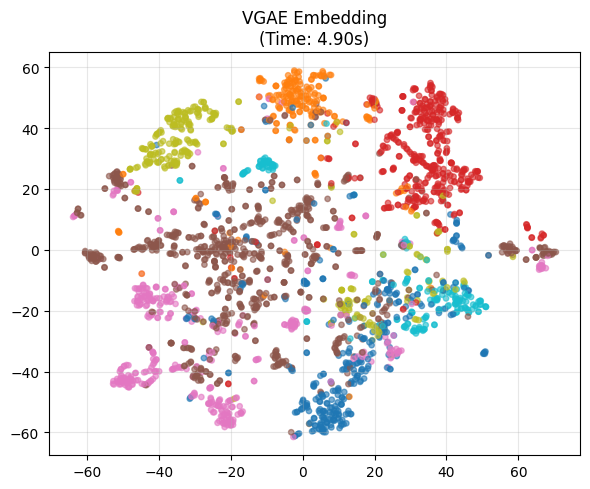

In [29]:
print("t-SNE VISUALIZATION OF EMBEDDINGS")
print("=" * 60)

node_labels = cora_data.y.numpy()
class_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
               'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

# Create t-SNE visualizations with optimal layout for 5 methods
fig, axes = plt.subplots(1, 1, figsize=(6, 5))

if torch.is_tensor(embedding):
    embedding_np = embedding.detach().numpy().astype(np.float32)
else:
    embedding_np = np.array(embedding, dtype=np.float32)

# Ensure data is finite and normalized
embedding_np = np.nan_to_num(embedding_np, nan=0.0, posinf=1.0, neginf=-1.0)

# Apply t-SNE for dimensionality reduction with robust parameters
tsne_model = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=min(30, len(embedding_np) - 1),  # Ensure perplexity < n_samples
    n_iter=1000,
    verbose=0,
    init='pca',
    learning_rate='auto'
)

embedding_2d = tsne_model.fit_transform(embedding_np)

# Create scatter plot
scatter = axes  .scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                            c=node_labels, cmap='tab10', alpha=0.6, s=15)

# Add method-specific styling
axes.set_title(f'VGAE Embedding\n(Time: {embedding_time:.2f}s)', fontsize=12)
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###  <a id='chapter6'> 🔗 <font color="grey">Alignment </font></a>

In [16]:
from l2gx.align import get_aligner
from examples.example import (
    generate_points, 
    voronoi_patches, 
    plot_patches, 
    transform_patches
)
from l2gx.align import procrustes_error
rg = np.random.default_rng()

In [ ]:
points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)
patches, centers = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=1, kmeans=False)
overlap_count = 0
for i in range(len(patches)):
    for j in range(i+1, len(patches)):
        overlap = len(set(patches[i].nodes) & set(patches[j].nodes))
        if overlap >= 64:
            overlap_count += 1

print(f"Patch pairs with sufficient overlap (≥64): {overlap_count}")

In [61]:
noise_level = 0 # 0.1
shift_scale = 10
scale_range = None #[0.01, 100]

# Create transformed copies of the patches
transformed_patches = [copy.deepcopy(p) for p in patches]

# Add noise to the transformed patches
if noise_level > 0:
    for patch in transformed_patches:
        noise = rg.normal(loc=0, scale=noise_level, size=patch.coordinates.shape)
        patch.coordinates += noise

transformed_patches = transform_patches(
    transformed_patches, 
    shift_scale=shift_scale, 
    scale_range=scale_range
    )

In [ ]:
plot_patches(patches, transformed_patches)

In [ ]:
aligner = get_aligner("geo2", verbose=True, min_overlap=64)
result = aligner.align_patches(transformed_patches, 
                      num_epochs=10000,
                      learning_rate=0.01,
                      use_orthogonal_reg=True,
                      orthogonal_reg_weight=1000,
                      use_bfs_training=True,
                      center_patches=False,
                      device="cpu" 
                      )
print(f"Alignment completed. Final loss: {result.loss_history[-1]:.6f}")
aligned_embedding = result.get_aligned_embedding()

_, _, procrustes_error = procrustes(points, aligned_embedding)
print(f"Procrustes error: {procrustes_error:.6f}")

plot_patches(patches, result.patches)

intermediate_patches = copy.deepcopy(result.patches)
result = aligner.align_patches(intermediate_patches, 
                      num_epochs=10000,
                      learning_rate=0.01,
                      use_orthogonal_reg=True,
                      orthogonal_reg_weight=1000,
                      use_bfs_training=True,
                      center_patches=False,
                      device="cpu" 
                      )

_, _, procrustes_error = procrustes(points, aligned_embedding)
print(f"Procrustes error: {procrustes_error:.6f}")

plot_patches(patches, result.patches)

In [ ]:
plot_patches(patches, aligner.patches)

In [ ]:
points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)
patches, centers = voronoi_patches(points, sample_size=2, min_degree=1, min_overlap=64, min_patch_size=128, eps=1, kmeans=False)
overlap_count = 0
for i in range(len(patches)):
    for j in range(i+1, len(patches)):
        overlap = len(set(patches[i].nodes) & set(patches[j].nodes))
        if overlap >= 64:
            overlap_count += 1

print(f"Patch pairs with sufficient overlap (≥64): {overlap_count}")

In [18]:
noise_level = 0 # 0.1
shift_scale = 10
scale_range = None #[0.01, 100]

# Create transformed copies of the patches
transformed_patches = [copy.deepcopy(p) for p in patches]

# Add noise to the transformed patches
if noise_level > 0:
    for patch in transformed_patches:
        noise = rg.normal(loc=0, scale=noise_level, size=patch.coordinates.shape)
        patch.coordinates += noise

transformed_patches = transform_patches(
    transformed_patches, 
    shift_scale=shift_scale, 
    scale_range=scale_range
    )

In [ ]:
plot_patches(patches, transformed_patches)

In [ ]:
aligner = get_aligner("geo2", verbose=True, min_overlap=64)
result = aligner.align_patches(transformed_patches, 
                      num_epochs=1000,
                      learning_rate=0.01,
                      use_orthogonal_reg=True,
                      orthogonal_reg_weight=10,
                      device="cpu",
                      center_patches=False
                      )
print(f"Alignment completed. Final loss: {result.loss_history[-1]:.6f}")
aligned_embedding = result.get_aligned_embedding()

_, _, procrustes_error = procrustes(points, aligned_embedding)
print(f"Procrustes error: {procrustes_error:.6f}")

plot_patches(patches, aligner.patches)

In [ ]:
geo_aligner = get_aligner(
    "geo",
    num_epochs=10000,
    learning_rate=0.001,
    model_type="affine",
    use_orthogonal_reg=True,
    orthogonal_reg_weight=10,
    center_patches=True,
    preserve_scale=False,
    min_overlap=64,
    verbose=True)
geo_aligner.align_patches(transformed_patches, min_overlap=64, scale=False)
embedding = geo_aligner.get_aligned_embedding()
plot_patches(patches, geo_aligner.patches)

In [ ]:
procrustes_error(points, embedding)

In [ ]:
geo_aligner.debug_alignment_step_by_step(transformed_patches)

In [ ]:
geo_aligner.diagnose_alignment_issues()

In [ ]:
geo_aligner.check_overlap_statistics()

In [ ]:
plt.plot(geo_aligner.loss_hist)
plt.show()

In [ ]:
l2g_aligner = get_aligner("l2g")
l2g_aligner.align_patches(transformed_patches, scale=True)
embedding = l2g_aligner.get_aligned_embedding()
plot_patches(patches, l2g_aligner.patches)

In [ ]:
procrustes_error(points, embedding)

###  <a id='chapter7'> <font color="grey">7. Hierarchical alignment </font></a>

To be done.

###  <a id='chapter8'> <font color="grey">8. Visualisation </font></a>

For the visualisation, it is convenient to use external packages such as Heimdall.